<center><h1> America's Changing Priorities</h1></center>

The State of the Union (SOTU) address is delivered annually, and is the President's opportunity to outline his/her legislative agenda for the upcoming year to the US Congress. Since the advent of mass media the SOTU has been broadcast live and has been used by the President to not only present his/her agenda to Congress but to communicate his/her vision of the future to the citizens of the United States. The text of SOTU addresses is an example of unstructured data with (hopefully) information content about each President's vision and legislative agenda.

With that in mind, I decided to mine the SOTU addresses using bigram frequencies. I chose bigram frequencies because I hypothesized the frequency might be interpreted as relative importance of the agenda to the president and bigrams because I thought that would be the smallest interpretable unit able to be compared across years and presidencies.

In [6]:
from __future__ import division
import nltk, re, pprint
from bs4 import BeautifulSoup
import urllib2
from nltk.corpus import stopwords
import pandas as pd

Unfortunately, there is not a uniform URL to download the annual SOTU address from whitehouse.gov because it occurs on a different date each year. After hard-coding the urls the readSOTU function was created. It is a simple function that reads a URL and returns the raw text from a website. 

In [2]:
#2010 - 2015 SOTU, respectively
url2010 = 'https://www.whitehouse.gov/the-press-office/remarks-president-state-union-address'
url2011 = 'https://www.whitehouse.gov/the-press-office/2011/01/25/remarks-president-state-union-address'
url2012 = 'https://www.whitehouse.gov/the-press-office/2012/01/24/remarks-president-state-union-address'
url2013 = 'https://www.whitehouse.gov/the-press-office/2013/02/12/remarks-president-state-union-address'
#clean script won't work on 2014, it will work again for 2015
url2014 = 'https://www.whitehouse.gov/the-press-office/2014/01/28/president-barack-obamas-state-union-address'
url2015 = 'https://www.whitehouse.gov/the-press-office/2015/01/20/remarks-president-state-union-address-january-20-2015'
def readSOTU(url):
    page = urllib2.urlopen(url).read()
    soup = BeautifulSoup(page)
    rawText = soup.get_text()
    return rawText

Next a function was written to prepare the raw website text for mining. The cleanSOTU function prepares the text by:
- Removing unspoken descriptor tokens, e.g. (Applause.)
- Finding the word index of two tokens and returning only the text contained between them
- Converting all tokens to lowercase
- Removing punctuation

In [3]:
def cleanSOTU(rawText, idx1, idx2):
    """
    cleans state of the union text by removing audience reaction descriptors (e.g. (Applause.)), punctuation,
    and unwanted website text. Also changes all characters to lowercase and and returns a nltk text object.
    """
    noApp = re.sub(r'\([^)]*\)', '', rawText)
    tokens2010 = nltk.word_tokenize(noApp)
    first = tokens2010.index(idx1)
    first = first + 1
    last = tokens2010.index(idx2)
    speech = tokens2010[first:last]
    stop = set(stopwords.words('english'))
    filteredspeech = [w.lower() for w in speech if w.lower() not in stop and w.isalpha()]
    procText = nltk.Text(filteredspeech)
    return procText


Finally, the findagenda function will 
- create bigrams from cleaned text 
- find the frequency of each bigram in the text
- return the most frequent 7 (or more) bigrams 

The algorithm does this by continually lowering the bigram frequency threshold until at least 7 bigrams are obtained. A weakness of this algorithm is that if few bigrams occur with high frequently the algorithm will return many more low frequency bigrams than the desired 7.

In [4]:
def findagenda(cleanText):
    """
    finds the most frequent 7 (or more) bigrams and returns a list of bigrams and counts
    """
    bgs = nltk.bigrams(cleanText)
    fdist = nltk.FreqDist(bgs)
    num = 0
    filt = 10
    while num < 7:
        result = [(k,v) for (k,v) in fdist.items() if v >=filt]
        num = len(result)
        filt -= 1
        if num >= 7:
            return {k[0]+' '+ k[1]:v for (k,v) in result}


The mineSOTU function is a wrapper for the previous three functions and returns a DataFrame.

In [7]:
urls = [url2010, url2011, url2012, url2013, url2015]
years = ['2010','2011','2012','2013','2015']
def mineSotu(urls, years, idx1, idx2):
    speeches = [readSOTU(url) for url in urls]
    allspeeches = dict(zip(years, speeches))
    cleanspeeches = {k:cleanSOTU(v, idx1, idx2) for (k,v) in allspeeches.items()}
    agendas = {k:findagenda(v) for (k,v) in cleanspeeches.items()}
    return pd.DataFrame(agendas)

obamaSOTU = mineSotu(urls, years, 'PRESIDENT', 'END')

The 2014 speech was formatted differently, so the index words were different.

In [11]:
def readcleanSOTU2014(url):    
    rawText = readSOTU(url)
    procText = cleanSOTU(rawText, 'Release', 'Latest')
    result = findagenda(procText)
    resultdf = pd.DataFrame(index = result.keys(), data = result.values(), columns = ['2014'])
    return resultdf

SOTU2014 = readcleanSOTU2014(url2014)

Joining the two dataframes and the structure of the consolidated DataFrame.

In [14]:
obamaSOTU = obamaSOTU.join(SOTU2014, how='outer')
SOTU2015 = obamaSOTU.pop('2015')
obamaSOTU['2015'] = SOTU2015
obamaSOTU1 = obamaSOTU.fillna(0)
obamaSOTU1.head(5)

,2010,2011,2012,2013,2014,2015
american diplomacy,0,0,0,0,4,0
american people,11,0,0,6,4,4
better politics,0,0,0,0,0,5
built last,0,0,5,0,0,0
business leaders,0,0,0,0,4,0


The heatplot function formats and plots a heatmap to easily visualize the values in the DataFrame.

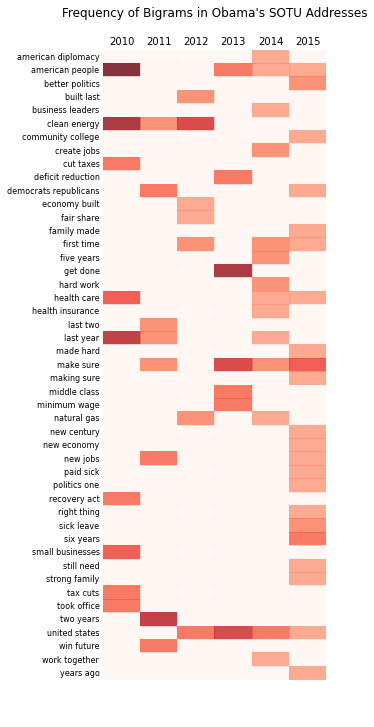

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def heatplot(SOTU, name, axis1, axis2):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(SOTU, cmap=plt.cm.Reds, alpha=0.8)
    fig = plt.gcf()
    fig.set_size_inches(axis1, axis2)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(SOTU.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(SOTU.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(list(SOTU.columns),minor = False)
    ax.set_yticklabels(SOTU.index, fontsize=8)
    ax.grid(False)
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks(): 
        t.tick1On = False 
        t.tick2On = False 
    for t in ax.yaxis.get_major_ticks(): 
        t.tick1On = False 
        t.tick2On = False 
    plt.text(0.5,1.05,'Frequency of Bigrams in '+name+'\'s SOTU Addresses',
             fontsize=12, horizontalalignment='center', 
             transform=ax.transAxes)
    plt.show()

heatplot(obamaSOTU1, 'Obama', 4, 12)

An observation that is immediately apparent is the difference in the number of bigrams present at the beginning of Barack Obama's presidency (9) as compared to his most recent SOTU address (22). This might indicate a legislative strategy focused on a few key issues in his early years and a broadening agenda in his second term. Two agendas have appeared in three SOTU addresses during his presidency, health care and clean energy. The most frequently used interpretable bigram is clean energy, not particularly surprising given that it has appeared over multiple years and early in the presidency.

In [18]:
obamaSOTU.count(axis=0)

2010     9
2011     8
2012     7
2013     7
2014    14
2015    22
dtype: int64

Whitehouse.gov no longer archives George W. Bush's SOTU address but the following website is easily queried. Iterating through the relevant years provides easy access to the desired SOTU address.

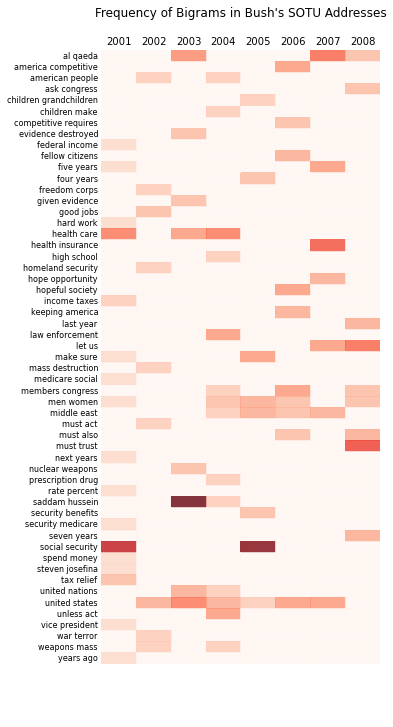

In [19]:
years = range(2001,2009)
bushurls = ['http://www.let.rug.nl/usa/presidents/george-w-bush/state-of-the-union-' +str(year)+ '.php' for year in years]
bushSOTU = mineSotu(bushurls, years, 'Speaker', 'HomeOutlinesDocumentsEssaysBiographiesPresidents')
bushSOTU1 = bushSOTU.fillna(0)
heatplot(bushSOTU1, 'Bush', 5, 12)

Interestingly, George W. Bush seems to have adopted a strategy opposite Barack Obama. More bigrams were present in his early speeches indicating a broad legislative agenda that narrowed during the second term of his presidency. The two most frequent topics were Saddam Hussein in 2003 and Social Security in 2005. Three agendas appeared in three SOTU addresses throughout Bush's presidency, al qaeda, the middle east, and health care.

In [21]:
bushSOTU.count(axis=0)

2001    17
2002     9
2003     8
2004    14
2005     8
2006    10
2007     7
2008     9
dtype: int64

Inspection of the two heatmaps reveals George W. Bush was more likely to have bigrams related to national security or social programs in his SOTU addresses while Barack Obama was more likely to have bigrams referencing the economy and energy. Both presidents pay homage to taxes and healthcare. Remarkably, while both presidents seemed to have a single theme dominating their presidency neither president appears to have a single constant agenda, with the same or similar bigram appearing in every SOTU address, and lasting throughout the presidency. 

After drilling down into the differences between presidents the bigram frequencies might also reveal other trends. At a micro-level the style of the president's speech writers and their preference for specific word combinations might be reflected in the bigram distribution. At a macro-level the changing bigram frequencies over time could be interpreted as a compact history of our nation's changing priorities. 